In [105]:
import pandas as pd
import all_individual_stats
import env
import api_exp
import find_player_in_histories_file
import numpy as np
import add_team_data
import os
import split
import modeling as md
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import prepare
import sklearn.preprocessing


import pandas as pd
from scipy import stats
from pydataset import data


%load_ext autoreload
%autoreload 2

folder = '/Users/kylegreen/codeup-data-science/time-series-exercises/riot_api_data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
aggregates = pd.read_csv(folder + 'aggregates.csv')
aggregates = aggregates.drop(columns=['index', 'match_id'])
aggregates.head()

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win
0,0,-0.101898,-0.105035,-1,3.0,-0.111111,-1.0
1,0,-0.183252,-0.090136,0,-0.6,-0.011364,-1.0
2,1,-0.051555,-0.183364,0,3.2,0.378788,1.0
3,0,0.021739,0.200000,0,0.0,0.400000,1.0
4,-1,0.121032,0.020727,0,0.6,-0.214286,-1.0


In [67]:
aggregates = aggregates[(aggregates.mean_session_games > -15) & (aggregates.mean_session_games < 100)]
aggregates.head()

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win
0,0,-0.101898,-0.105035,-1,3.0,-0.111111,-1.0
1,0,-0.183252,-0.090136,0,-0.6,-0.011364,-1.0
2,1,-0.051555,-0.183364,0,3.2,0.378788,1.0
3,0,0.021739,0.200000,0,0.0,0.400000,1.0
4,-1,0.121032,0.020727,0,0.6,-0.214286,-1.0


In [115]:
train, validate, test= split.train_validate_test_split(aggregates.dropna(), 'win')
train.head()

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win
88,-2,0.015152,-0.329018,0,-0.2,-0.500000,-1.0
24,-1,0.062500,-0.352239,-1,-3.2,-0.444444,-1.0
66,1,0.036508,-0.154826,0,1.0,-0.200000,-1.0
81,2,0.086438,-0.140120,1,0.8,0.166667,1.0
6,2,-0.111111,-0.214474,0,-0.4,-0.133333,1.0


## Scaling

In [116]:
# define min/max scaler
scaler = sklearn.preprocessing.MinMaxScaler()

# function to returned scaled datasets
train_scaled, validate_scaled, test_scaled, scaler = prepare.fit_and_scale(scaler, train, validate, test)
train_scaled.head()

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win
0,0.2,0.440158,0.248976,0.5,0.296296,0.294118,0.0
1,0.4,0.477803,0.216010,0.0,0.111111,0.326797,0.0
2,0.8,0.457138,0.496270,0.5,0.370370,0.470588,0.0
3,1.0,0.496835,0.517146,1.0,0.358025,0.686275,1.0
4,1.0,0.339771,0.411589,0.5,0.283951,0.509804,1.0


### Univariate distributions

total_on_role


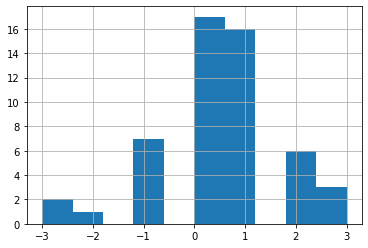

mean_champ_win_rate


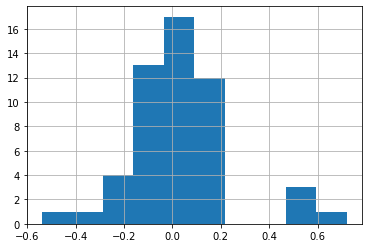

mean_role_win_rate


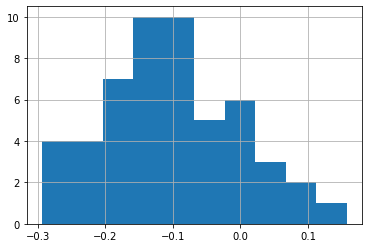

jg_on_role


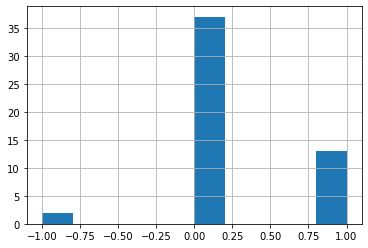

mean_session_games


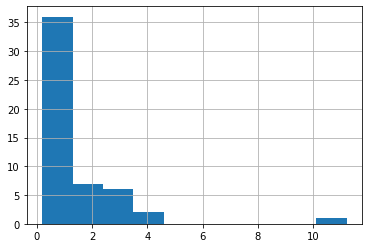

aggregate_session_win_rate


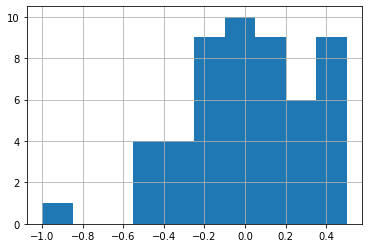

win


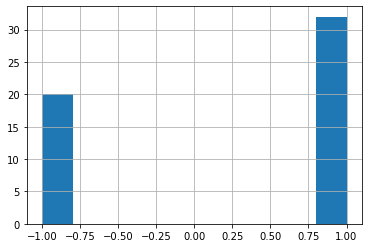

jg_on_role_mean_role_win_cluster


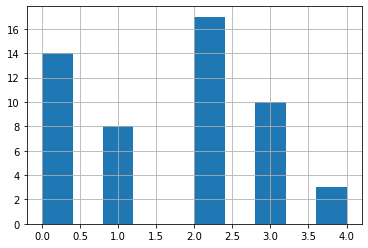

In [61]:
for col in aggregates.columns:
    aggregates[col].hist(label=col)
    print(col)
    plt.show()
    

### Datatypes for statistical analysis

categorical - jg on role, win
continuous - mean_champ_winrate, mean_role_win_rate, mean_session_games, aggregate_session_win_rate

#### notes:
>> Normally distributed: total_on_role, mean_champ_win_rate, mean_role_win_rate
>> left skew: aggregate_session_win_rate
>> heavy right skew: mean_session_games




### statistical test:

>> categorical: Chi squared on jg on role vs win

> Hypothesis: when jg on role is 1 or -1(one team has a jg on role while other team does not), it creates a significant advantage and increases win percentage for the team that has the jg on role.

>> continuous vs categorical: T-Test. 

> Teams that have higher winrates on their champions will win more games                                          
>           Teams with higher winrates within their role will win more games




### clustering:

>> cluster on categories that I believe affect the target variable, as well as different win rates.



ValueError: cannot reindex from a duplicate axis

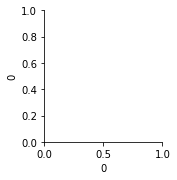

TypeError: 'str' object is not callable

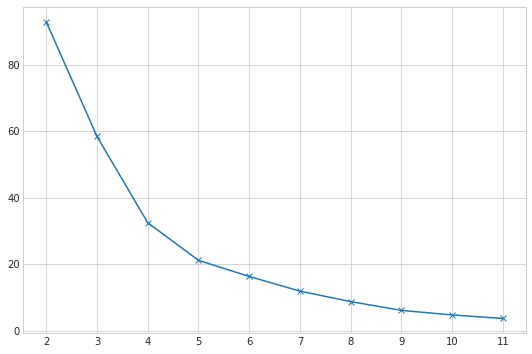

In [109]:
X = train[['mean_champ_win_rate', 'mean_role_win_rate', 'total_on_role','win']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [29]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

aggregates['jg_on_role_mean_role_win_cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)



<AxesSubplot:xlabel='win', ylabel='jg_on_role'>

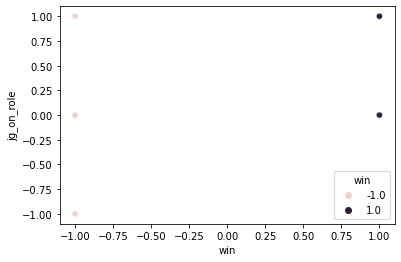

In [27]:
sns.scatterplot(X., X.jg_on_role, hue=X.win)


In [ ]:
plt.figure(figsize=(14, 9))

for cluster, subset in iris.groupby('clusters'):
    plt.scatter(aggregates.mean_role_win_rate, subset.petal_width, label='clusters' + str(cluster), alpha=.6)

centroids.plot.scatter(y='win', x='mean_role_win_rate', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('sepal_width')
plt.ylabel('petal_width')
plt.title('Visualizing Cluster Centers')

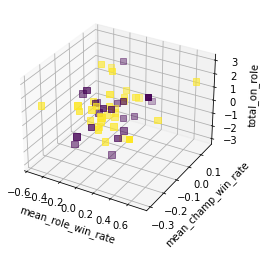

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(X.mean_champ_win_rate)
y = np.array(X.mean_role_win_rate)
z = np.array(X.total_on_role)

ax.scatter(x,y,z, marker='s', c=X.win, s=40)

ax.set_ylabel('mean_champ_win_rate')
ax.set_xlabel('mean_role_win_rate')
ax.set_zlabel('total_on_role')
plt.show()

In [34]:
aggregates[(aggregates.mean_role_win_rate < 0) & (aggregates.mean_champ_win_rate < 0) & (aggregates.total_on_role < 0)]

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win,jg_on_role_mean_role_win_cluster
52,-2,-0.266667,-0.183028,0,0.6,-0.238636,-1.0,4
65,-1,-0.096642,-0.111026,0,1.0,-0.147059,1.0,0


In [35]:
aggregates[(aggregates.mean_role_win_rate > 0) & (aggregates.mean_champ_win_rate > 0) & (aggregates.total_on_role > 0)]

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win,jg_on_role_mean_role_win_cluster
76,1,0.051613,0.004349,0,0.4,-0.083333,1.0,2
97,2,0.719298,0.102123,1,1.0,0.484848,1.0,2


In [47]:
len(aggregates[(aggregates.jg_on_role != 0) & (aggregates.jg_on_role == aggregates.win)]) / len(aggregates[aggregates.jg_on_role != 0])

0.8

In [43]:
aggregates[aggregates.jg_on_role < 0]

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win,jg_on_role_mean_role_win_cluster
0,0,-0.101898,-0.105035,-1,3.0,-0.111111,-1.0,3
102,0,-0.047619,-0.291915,-1,0.2,-0.416667,-1.0,3


In [57]:
aggregates[aggregates.mean_session_games > 1].sort_values(by='mean_session_games', ascending=False).win.sum()

9.0

In [58]:
len(aggregates[(aggregates.mean_session_games > 1) & (aggregates.win == 1)]) / len(aggregates[aggregates.mean_session_games > 1])

0.7142857142857143

### Notes:

winrate of population with mean session games of greater than one is significantly higher than 50%

In [68]:
len(aggregates[(aggregates.mean_session_games < -1) & (aggregates.win == -1)]) / len(aggregates[aggregates.mean_session_games < -1])

0.5263157894736842

In [71]:
aggregates[aggregates.mean_session_games < -1]

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win
8,2,0.082500,0.050304,1,-2.0,0.026756,1.0
10,-1,NaN,-0.037313,0,-2.6,0.250000,1.0
15,-1,0.314286,-0.249376,-1,-1.4,0.625000,1.0
22,2,-0.246091,-0.386601,0,-1.4,-0.358974,1.0
24,-1,0.062500,-0.352239,-1,-3.2,-0.444444,-1.0
37,-4,NaN,-0.388390,-1,-6.4,0.147059,-1.0
41,-1,-0.094017,-0.297216,0,-2.0,0.583333,-1.0
46,0,0.007515,-0.327817,-1,-1.4,0.204545,1.0
61,-1,-0.144796,-0.357660,1,-2.2,-0.500000,-1.0
69,-2,0.515152,-0.199076,-1,-2.0,0.395833,1.0


In [92]:
def blue_team_win_by_col(df, col, thresh=0):
    return len(df[(df[col] > thresh) & (df.win == 1)]) / len(df[df[col] > thresh])

def red_team_win_by_col(df, col, thresh=0):
    return len(df[(df[col] < thresh) & (df.win == -1)]) / len(df[df[col] < thresh])

def team_by_col(df,  col, team):
    if team == 'red':
        return df[df[col] <= 0]
    elif team== 'blue': 
        return df[df[col] >= 0]

In [81]:
blue_team_win_by_col(aggregates, 'jg_on_role')

0.6470588235294118

In [82]:
red_team_win_by_col(aggregates, 'jg_on_role')

0.55

## Chi squared

In [ ]:
Null Hypothesis: Whether a team has a jg role advantage or not is independent of whether they will win or not.
Alternative Hypothesis: Whether a team has a jg role advantage or not is related to whether or not they will win.

In [99]:
observed = pd.crosstab(aggregates.jg_on_role, aggregates.win)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'p value {p}')
print(f'chi2: {chi2}')

p value 0.48579100924253815
chi2: 1.4439535394047431


In [87]:
observed = pd.crosstab(aggregates[aggregates.jg_on_role !=0].jg_on_role, aggregates[aggregates.jg_on_role !=0].win)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'p value {p}')
print(f'chi2: {chi2}')


p value 0.38556505587724355
chi2: 0.7528827854671276


In [95]:
red_jg_adv = team_by_col(aggregates, 'jg_on_role', 'red')
red_jg_obsv = pd.crosstab(red_jg_adv.jg_on_role, red_jg_adv.win)
chi2, p, degf, expected = stats.chi2_contingency(red_jg_obsv)
print(f'p value {p}')
print(f'chi2: {chi2}')


p value 0.7083529128155183
chi2: 0.13992768595041305


In [96]:
blue_jg_adv = team_by_col(aggregates, 'jg_on_role', 'blue')
blue_jg_obsv = pd.crosstab(blue_jg_adv.jg_on_role, blue_jg_adv.win)
chi2, p, degf, expected = stats.chi2_contingency(blue_jg_obsv)
print(f'p value {p}')
print(f'chi2: {chi2}')



p value 0.5551598061215766
chi2: 0.34815428949060667


We fail to reject the null hypothesis on all levels.

In [111]:
train_scaled

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win
0,0.500000,0.325302,0.218350,0.5,0.400000,0.416667,0.0
1,0.833333,1.000000,0.916903,1.0,0.600000,0.873440,1.0
2,0.333333,0.351275,0.594676,0.5,0.600000,0.501730,1.0
3,0.333333,0.477803,0.230023,0.0,0.000000,0.326797,0.0
4,0.333333,0.524655,1.000000,0.5,0.628571,0.833872,0.0
5,0.666667,0.507812,0.697639,0.5,0.514286,0.759804,1.0
6,0.666667,0.522005,0.437718,1.0,0.542857,0.739496,1.0
7,0.666667,0.521754,0.609381,0.5,0.371429,0.392157,1.0
8,0.333333,0.136588,0.494985,0.5,0.314286,1.000000,1.0
9,0.500000,0.390251,0.321217,0.0,0.485714,0.343137,0.0


In [136]:
train.sort_values(by='aggregate_session_win_rate', ascending=False)

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win
39,-1,-0.366667,-0.176970,0,-1.0,0.700000,1.0
15,-1,0.314286,-0.249376,-1,-1.4,0.625000,1.0
41,-1,-0.094017,-0.297216,0,-2.0,0.583333,-1.0
64,0,-0.009600,-0.126420,-1,-0.2,0.500000,1.0
97,2,0.719298,0.102123,1,1.0,0.484848,1.0
74,-1,-0.064935,-0.449253,0,-5.0,0.481481,-1.0
32,1,-0.082500,-0.083314,-1,0.0,0.461538,-1.0
70,2,-0.187534,0.041094,1,1.2,0.428571,1.0
62,-1,0.121429,0.157091,0,1.2,0.417582,-1.0
3,0,0.021739,0.200000,0,0.0,0.400000,1.0


In [119]:
dt_mods, rf_mods, knn_mods, lr_mods= md.all_reports(train, validate,test, 'win')
md.Results.total_summary[['model_type', 'train_accuracy', 'validate_accuracy']].sort_values(by='validate_accuracy', ascending=False)

,model_type,train_accuracy,validate_accuracy
18,knn_distance,1.000000,0.583333
1,knn_uniform,0.732143,0.583333
16,knn_distance,1.000000,0.541667
16,knn_distance,1.000000,0.541667
2,knn_uniform,0.767857,0.541667
...,...,...,...
12,knn_uniform,0.607143,0.375000
5,knn_uniform,0.625000,0.375000
14,random_forests,1.000000,0.375000
11,knn_uniform,0.571429,0.333333


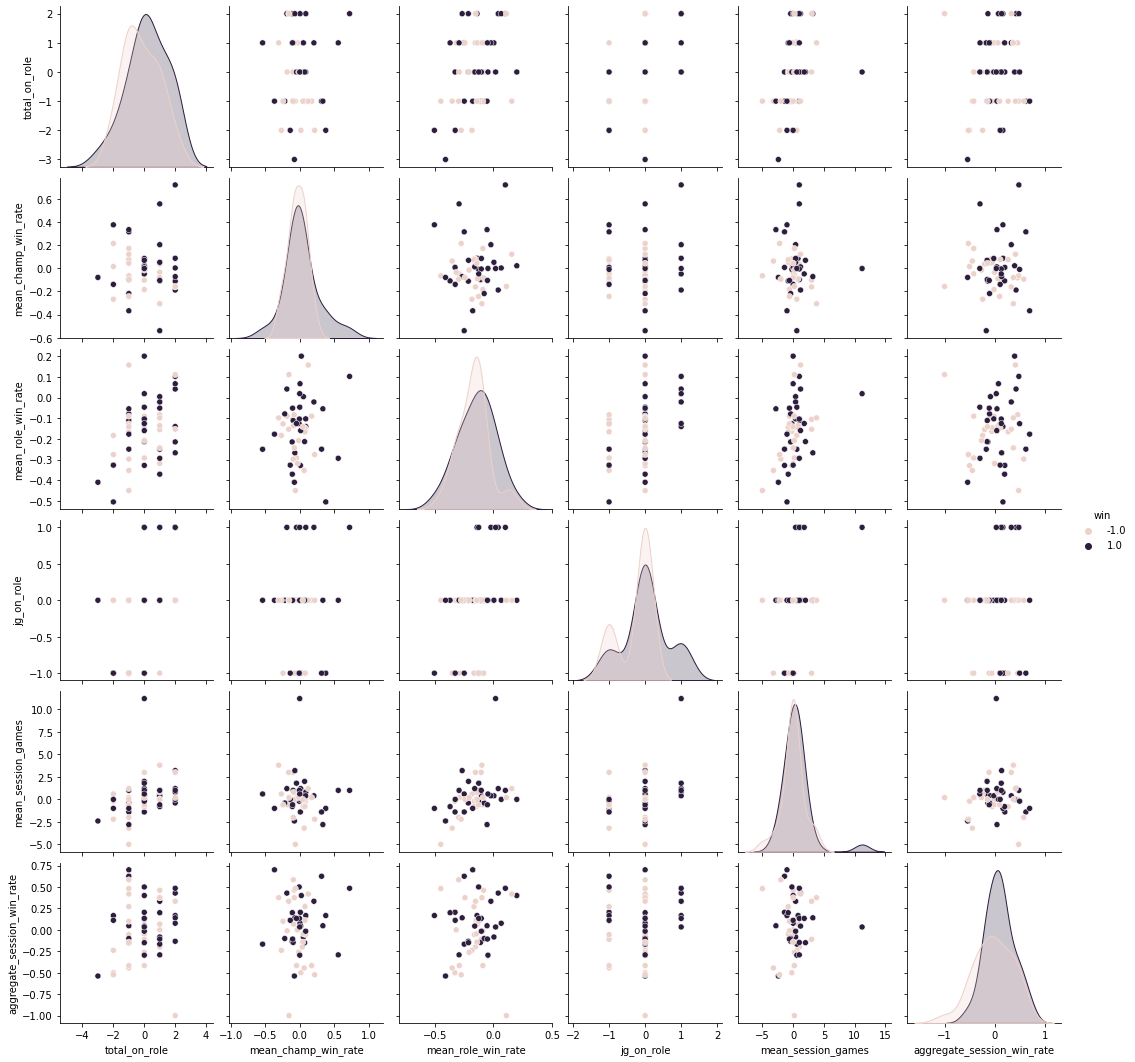

In [134]:
sns.pairplot(data=train,hue='win')

T-Tests:





Do teams that win have a higher champion winrate going into the game than teams that don't?



In [138]:
train.head()

,total_on_role,mean_champ_win_rate,mean_role_win_rate,jg_on_role,mean_session_games,aggregate_session_win_rate,win
88,-2,0.015152,-0.329018,0,-0.2,-0.500000,-1.0
24,-1,0.062500,-0.352239,-1,-3.2,-0.444444,-1.0
66,1,0.036508,-0.154826,0,1.0,-0.200000,-1.0
81,2,0.086438,-0.140120,1,0.8,0.166667,1.0
6,2,-0.111111,-0.214474,0,-0.4,-0.133333,1.0


In [140]:
win_sample = train[train.win == 1].mean_champ_win_rate
overall_mean = train.mean_champ_win_rate.mean()

t, p = stats.ttest_1samp(win_sample, overall_mean)
print(t, p/2)

0.6383670953779431 0.26412211193483637


Do teams that win have a higher role winrate going into the game than teams that don't?



In [141]:
win_sample = train[train.win == 1].mean_role_win_rate
overall_mean = train.mean_role_win_rate.mean()

t, p = stats.ttest_1samp(win_sample, overall_mean)
print(t, p/2)

0.4637264625158759 0.3231528510471714


Do teams that win have a higher session winrate going into the game than teams that don't?

In [143]:
win_sample = train[train.win == 1].aggregate_session_win_rate
overall_mean = train.aggregate_session_win_rate.mean()

t, p = stats.ttest_1samp(win_sample, overall_mean)
print(t, p/2)

1.1395754740986486 0.13189433453280966
